# Imports

In [13]:
import os
import sys
import pdb
import math
import time
import random 
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from pathlib import Path
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt

import matplotlib.path as mpltPath
from sklearn.metrics import pairwise_distances
from scipy.spatial import Delaunay
from scipy.stats import zscore

hpc = True
work_desktop = False
work_linux = True
singularity = True
prj = "HCC-CBS-150-Hillman-BFerris-15132-HN-Vectra"
if not hpc:
    if work_desktop:
        if work_linux == True:
            base = Path('/mnt/d/OneDrive - University of Pittsburgh/Internal_Project_Data_2/' + prj)
        else:
            base = Path(r'D:\OneDrive - University of Pittsburgh\Internal_Project_Data_2').joinpath(prj)
    else: #Laptop
        base = Path('/home/brian/data/odrive/Internal_Project_Data_2/'+prj)
else:
    if singularity:
        base = Path('/mnt') 
    else:
        base = Path('/ix/rbao/Projects/' + prj)
scripts = base.joinpath('scripts')
                        
#Custom helper functions:
sys.path.append(str(scripts.joinpath('inform_vectra_tools')))
import vecutils as vecUtils
import vectra as vectra
sys.path.append(str(scripts.joinpath('inform_vectra_tools','delaunay')))
import delaunay as delHelpers
import delaunayPlots as delPlots

%load_ext autoreload
%autoreload 2

results = base.joinpath('bi_results')
data =  results.joinpath('qupath','round_3','cell_exports')
print(data.exists(),'data exists')
sampleinfo = base.joinpath('sampleinfo')
print(data.exists())
all_fns = np.sort([str(x) for x in data.rglob('*Detections.txt')])
print('vectra outputs',len(all_fns))
c_tma = 0
c_wts = 0
for fn in all_fns:
    if 'TMA' in fn:
        c_tma = c_tma + 1
    else:
        c_wts = c_wts + 1
print('TMA:',c_tma, 'WTS:', c_wts)

#Load in an example
txt = [data.joinpath(all_fns[3])]
print(txt)
df = pd.read_csv(txt[0], sep='\t',index_col=1)
clean_clin = pd.read_csv(sampleinfo.joinpath('bi_clean_clin_85_8.csv'),index_col=0)
clean_clin.head(n=6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True data exists
True
vectra outputs 71
TMA: 0 WTS: 71
[PosixPath('/mnt/bi_results/qupath/round_3/cell_exports/MISP0099Q004_Scan2_Detections.txt')]


,clin_sample_id,tissue_id,pt_id,time_point,time_point_all,arm,batch,collection_date
0,MISP0099Q0001,MISP0099Q001,2,post,W2 on tx,B,1,2016-06-30
1,MISP0099Q0002,MISP0099Q002,1,pre,pre,A,1,2016-06-06
2,MISP0099Q0003,MISP0099Q003,1,post,W2 on tx,A,1,2016-07-06
3,MISP0099Q0004,MISP0099Q004,3,pre,pre,A,1,2016-06-30
4,MISP0099Q0005,MISP0099Q005,3,post,W2 on tx,A,1,2016-07-28
5,MISP0099Q0006,MISP0099Q006,4,pre,pre,B,1,2016-08-08


# Add in exploration of Delauney triangulation for neighborhood analysis
As per 2021 Nat. Comm. paper:
"Finally, we analyzed the key cell-cell neighborhoods
associated with TLS with GC vs. TLS without GC in HNSCC (Fig. 6g). In TLS with GC, TIL-Bs interact with other TIL-Bs and CD4+ Tconv TIL, which is in line with the working definition of an active GC. Interestingly, an evaluation of TLS without GC in HNSCC revealed that TIL-Bs were not frequently in the same neighborhood with CD4+ Tconv, and instead CD8+ TIL and Tregs were implicated as a dominant interaction. These results demonstrate that in TLS with GC, the spatial patterning becomes distinct from well-infiltrated tumors where immune cells are found in aggregates."

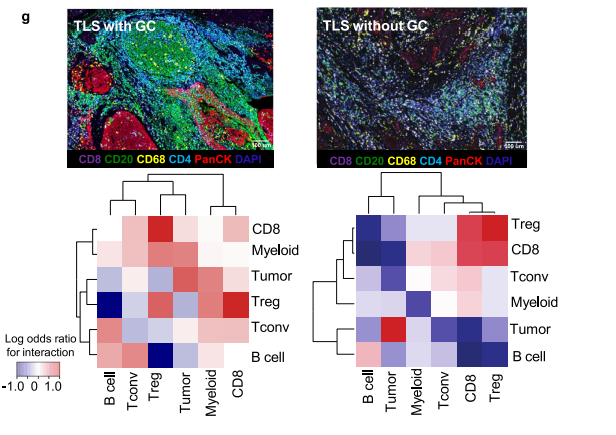

In [ ]:
pil_im = Image.open('./nat_comm_2021_neighbors.png')
display(pil_im)

# Delaunay helper tests

In [8]:
df.Class.unique()

array([nan, 'CD3', 'FOXP3: CD3', 'CD8: CD3', 'CD8', 'PD-1: CD3',
       'PanCK: CD3', 'PanCK: PD-1: CD3', 'PD-1: CD8: CD3',
       'FOXP3: CD8: CD3', 'FOXP3: PanCK: CD3', 'FOXP3', 'PD-L1: CD3',
       'FOXP3: PD-1: CD3', 'PD-L1', 'FOXP3: PD-L1: CD3',
       'PD-L1: PD-1: CD3', 'PD-1', 'PanCK', 'FOXP3: PD-L1: PD-1: CD3',
       'PD-L1: CD8: CD3', 'FOXP3: PD-L1: PD-1: CD8: CD3',
       'PD-L1: PD-1: CD8: CD3', 'FOXP3: PD-1: CD8: CD3',
       'PanCK: CD8: CD3', 'FOXP3: PD-L1', 'PanCK: PD-L1',
       'PanCK: PD-1: CD8: CD3', 'PanCK: PD-L1: CD8: CD3', 'PD-L1: CD8',
       'FOXP3: CD8', 'PanCK: PD-L1: CD3', 'PD-1: CD8', 'PanCK: CD8',
       'PanCK: PD-1', 'FOXP3: PanCK: CD8: CD3', 'FOXP3: PanCK: PD-1: CD3',
       'PanCK: PD-L1: PD-1: CD8: CD3', 'FOXP3: PanCK', 'PD-L1: PD-1',
       'PanCK: PD-L1: PD-1: CD3', 'FOXP3: PanCK: PD-L1',
       'FOXP3: PanCK: PD-L1: PD-1: CD8', 'PanCK: PD-L1: PD-1',
       'FOXP3: PanCK: PD-L1: PD-1', 'FOXP3: PanCK: PD-L1: PD-1: CD3'],
      dtype=object)

In [22]:
df.Parent.unique()

array(['Stroma', 'Outer margin', 'Inner margin', 'Center'], dtype=object)

False

In [40]:
#The order matters! -> the more inclusive types must be defined before the more specific types 
# i.e. more specific cells will be removed from broader (single marker) categories

multi_label_types = {
     #PDL1
     'PDL1+_tiv_inner': {'PD-L1': True,
                        'tissue':'Inner margin'}, 
     'PDL1+_tiv_outer': {'PD-L1': True,
                        'tissue':'Outer margin'},   
     'PDL1+_central_tumor': {'PD-L1': True,
                           'tissue': 'Center'},   

     #PDL1
     'PDL1-_tiv_inner': {'PD-L1': False,
                        'tissue':'Inner margin'}, 
     'PDL1-_tiv_outer': {'PD-L1': False,
                        'tissue':'Outer margin'},   
     'PDL1-_central_tumor': {'PD-L1': False,
                           'tissue': 'Center'}, 
     # T-Cell definitions
     'CD8_CD3_tiv_inner': {'CD3':True, 'CD8': True,
                           'tissue':'Inner margin'},      
     'CD8_CD3_tiv_outer': {'CD3':True, 'CD8': True,
                           'tissue':'Outer margin'},   
     'CD8_CD3_central_tumor': {'CD3':True, 'CD8': True, 
                           'tissue': 'Center'},  

     #PD1+ CD8 CD3
     'PD1_CD8_CD3_tiv_inner': {'CD3':True, 'CD8': True, 'PD-1': True,
                               'tissue':'Inner margin'}, 
     'PD1_CD8_CD3_tiv_outer': {'CD3':True, 'CD8': True, 'PD-1': True,
                               'tissue':'Outer margin'},   
     'PD1_CD8_CD3_central_tumor': {'CD3':True, 'CD8': True, 'PD-1': True,
                               'tissue': 'Center'},  

     #Tregs:
     'Treg_tiv_inner': {'CD3':True, 'FOXP3':True,
                        'tissue':'Inner margin'}, 
     'Treg_tiv_outer': {'CD3':True, 'FOXP3':True,
                        'tissue':'Outer margin'},   
     'Treg_central_tumor': {'CD3':True, 'FOXP3':True,
                        'tissue': 'Center'},  

     #PD1+ Tregs:
     'PD1_Treg_tiv_inner': {'CD3':True, 'FOXP3':True, 'PD-1': True,
                            'tissue':'Inner margin'}, 
     'PD1_Treg_tiv_outer': {'CD3':True, 'FOXP3':True, 'PD-1': True,
                            'tissue':'Outer margin'},   
     'PD1_Treg_central_tumor': {'CD3':True, 'FOXP3':True, 'PD-1': True,
                            'tissue': 'Center'},  


    }

In [16]:
df = vecUtils.vectra_if_types_to_cell_types(df.copy(),
                                 multi_label_dict= multi_label_types,
                                 col_dict={'tissue_col': 'Parent',
                                            'cell_col': 'Class',
                                            'cell_x_pos' : 'Centroid X µm',
                                            'cell_y_pos' : 'Centroid Y µm'},
                                 verbose = True,
                                 type_adds_tissue = True,
                                 exclusive = False,
                                 output_cell_type_col = 'cell_type',
                                )
df.cell_type.unique()

Class PD-L1 == True n= 1298 total 1298
Parent tissue == Inner margin n= 8211
	 Class Parent == PDL1+_tiv_inner n= 34
Class PD-L1 == True n= 1298 total 1298
Parent tissue == Outer margin n= 5238
	 Class Parent == PDL1+_tiv_outer n= 30
Class PD-L1 == True n= 1298 total 1298
Parent tissue == Center n= 13292
	 Class Parent == PDL1+_central_tumor n= 11
Class PD-L1 == False n= 36843 total 36843
Parent tissue == Inner margin n= 8211
	 Class Parent == PDL1-_tiv_inner n= 6513
Class PD-L1 == False n= 36843 total 36843
Parent tissue == Outer margin n= 5238
	 Class Parent == PDL1-_tiv_outer n= 2438
Class PD-L1 == False n= 36843 total 36843
Parent tissue == Center n= 13292
	 Class Parent == PDL1-_central_tumor n= 11450
Class CD3 == True n= 21400 total 21400
Class CD8 == True n= 1729 total 1511
Parent tissue == Inner margin n= 8211
	 Class Parent == CD8_CD3_tiv_inner n= 178
Class CD3 == True n= 21400 total 21400
Class CD8 == True n= 1729 total 1511
Parent tissue == Outer margin n= 5238
	 Class Paren

array([nan, 'CD3', 'FOXP3: CD3', 'CD8: CD3', 'CD8', 'PD-1: CD3',
       'PanCK: CD3', 'PanCK: PD-1: CD3', 'PD-1: CD8: CD3',
       'FOXP3: CD8: CD3', 'FOXP3: PanCK: CD3', 'FOXP3', 'PD-L1: CD3',
       'FOXP3: PD-1: CD3', 'PD-L1', 'FOXP3: PD-L1: CD3',
       'PD-L1: PD-1: CD3', 'PD-1', 'PanCK', 'FOXP3: PD-L1: PD-1: CD3',
       'PD-L1: CD8: CD3', 'FOXP3: PD-L1: PD-1: CD8: CD3',
       'PD-L1: PD-1: CD8: CD3', 'FOXP3: PD-1: CD8: CD3',
       'PanCK: CD8: CD3', 'FOXP3: PD-L1', 'PanCK: PD-L1',
       'PanCK: PD-1: CD8: CD3', 'PanCK: PD-L1: CD8: CD3', 'PD-L1: CD8',
       'FOXP3: CD8', 'PanCK: PD-L1: CD3', 'PDL1-_tiv_outer',
       'Treg_tiv_outer', 'CD8_CD3_tiv_outer', 'PD1_CD8_CD3_tiv_outer',
       'PDL1+_tiv_outer', 'PD1_Treg_tiv_outer', 'PDL1-_tiv_inner',
       'Treg_tiv_inner', 'CD8_CD3_tiv_inner', 'PD1_CD8_CD3_tiv_inner',
       'PDL1+_tiv_inner', 'PD1_Treg_tiv_inner', 'PDL1-_central_tumor',
       'CD8_CD3_central_tumor', 'Treg_central_tumor',
       'PDL1+_central_tumor', 'PD1_CD8

In [4]:
df.groupby('cell_type')['Class'].count()

cell_type
CD3                             12131
CD8                               107
CD8: CD3                          824
CD8_CD3_central_tumor             148
CD8_CD3_tiv_inner                 143
CD8_CD3_tiv_outer                 117
FOXP3                              85
FOXP3: CD3                       1525
FOXP3: CD8                          1
FOXP3: CD8: CD3                     6
FOXP3: PD-1: CD3                  105
FOXP3: PD-1: CD8: CD3               9
FOXP3: PD-L1                        2
FOXP3: PD-L1: CD3                  73
FOXP3: PD-L1: PD-1: CD3            21
FOXP3: PD-L1: PD-1: CD8: CD3        2
FOXP3: PanCK: CD3                   5
PD-1                               44
PD-1: CD3                        1334
PD-1: CD8: CD3                    131
PD-L1                             471
PD-L1: CD3                        495
PD-L1: CD8                          1
PD-L1: CD8: CD3                    27
PD-L1: PD-1: CD3                   84
PD-L1: PD-1: CD8: CD3              12
PD

('CD3', 'Stroma')
100 100
[   90    98    99   106 17900 17902]
[('CD8: CD3', 'Stroma'), ('CD3', 'Stroma'), ('CD3', 'Stroma'), ('PD-1: CD3', 'Stroma'), ('PD-1: CD3', 'Outer margin'), ('CD3', 'Outer margin')]
[[4733.3 2546.1]
 [4717.1 2556.6]
 [4729.  2559.2]
 [4720.4 2566.6]
 [4717.  2556.8]
 [4722.9 2560.1]]
[4722.8 2559.9]
[[4722.8 2559.9]]
[4733.3 2546.1]
(array([ True,  True,  True,  True,  True,  True]), array([17.34041522,  6.58634952,  6.239391  ,  7.11688134,  6.57647322,
        0.2236068 ])) 2 6


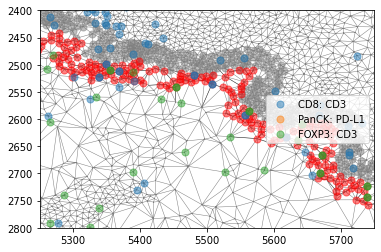

In [42]:
scale = 1
max_dist = 35 #microns
areas = ['Inner margin','Outer margin']

use_cells = ['CD8: CD3', 'PanCK: PD-L1','FOXP3: CD3']
col_dict = {'tissue_col': 'Parent',
            'cell_col': 'Class',
            'cell_x_pos' : 'Centroid X µm',
            'cell_y_pos' : 'Centroid Y µm'}

idx = ~df.loc[:,col_dict['cell_col']].isna() #df.Parent.isin(['Inner margin','Outer margin'])
subset=df.loc[idx,[x for x in col_dict.values()]]
idx = subset.loc[:,col_dict['cell_col']].isin(use_cells)
points = subset.loc[:,
                    (col_dict['cell_x_pos'],
                     col_dict['cell_y_pos'])
                   ].values
tri = Delaunay(points)
example = 100

point_lookup = delHelpers.df_to_cell_type_dict(subset,
                                               col_dict = col_dict
                                              )
print(point_lookup[tuple(points[example])])

print(example,delHelpers.point_to_vert(points,points[example]))

all_verts = delHelpers.vert_to_connected_verts(example,tri)
print(all_verts)

neighbor_cell_xy  = tri.points[all_verts]
print(delHelpers.point_list_to_celltype(neighbor_cell_xy,point_lookup))

neighbor_cell_xy  = tri.points[all_verts]
print(neighbor_cell_xy)
print(tri.points[example])
print(tri.points[example].reshape(1,-1))
print(tri.points[all_verts[0]])
is_neighbor = delHelpers.cell_dist_criterion(tri.points[example],
                                  neighbor_cell_xy,
                                  radius = max_dist)
print(is_neighbor,len(is_neighbor),len(all_verts))

plt.triplot(points[:,0], points[:,1],
            tri.simplices,
           color='gray',
           linewidth=0.5)

i=0
area_cols = ['gray','red']
for area in areas:
    idx = subset.loc[:,col_dict['tissue_col']].values == area
    cell_pts=subset.loc[idx,
                    (col_dict['cell_x_pos'],
                     col_dict['cell_y_pos'])
                   ].values
    plt.scatter(cell_pts[:,0],cell_pts[:,1], 
                50,
                marker='o',
                alpha = 0.5,
                color=area_cols[i])
    i = i + 1
cell_cols = ['cyan','green','yellow']    
i=0
for cell in use_cells:
    idx = subset.loc[:,col_dict['cell_col']].str.contains(cell)
    cell_pts=subset.loc[idx,
                    (col_dict['cell_x_pos'],
                     col_dict['cell_y_pos'])
                   ].values
    plt.scatter(cell_pts[:,0],cell_pts[:,1], 
                50,
                marker='o',
                alpha = 0.5, # color=cell_cols[i]
                label = cell,
                )
    i = i + 1
plt.legend(loc='right')
# plt.xlim([48800,48950])
# plt.ylim([5150,5250])
xmed = np.median(points[:,0])
ymed = np.median(points[:,1])
plt.xlim([5250,5750])
plt.ylim([2400,2800])

plt.gca().invert_yaxis()
plt.show()


# Example of going from a point to all neighboring vertices

[17219 17221 17223 17225]
[    1 17219 17221 17223 17225     1]
[False  True  True  True  True False]


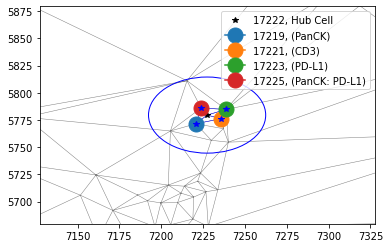

In [49]:
vert = 17222
plt.plot(tri.points[vert,0],tri.points[vert,1],'k*',
        label='%d, Hub Cell' % vert)

all_verts = delHelpers.vert_to_connected_verts(vert, tri)
print(all_verts)

plt.triplot(points[:,0], points[:,1],
            tri.simplices,
           color='gray',
           linewidth=0.5)

all_simp_with_vert = [i for i,s in enumerate(tri.simplices) \
                      if vert in s]
plt.triplot(points[:,0], points[:,1],
        tri.simplices[all_simp_with_vert],
        color='b',
        linewidth=0.5)
p = []
for vert_i in all_verts:
    cell_type = point_lookup[tuple(tri.points[vert_i])]
    label = '%d, (%s)' % (vert_i,cell_type[0])
    plt.plot(points[vert_i,0],points[vert_i,1],
             marker='o',
             label=label,
             markersize=15)
plt.legend()
win = 200
xmin = tri.points[vert,0] - (win/2)
xmax = xmin+ win

ymin = tri.points[vert,1] - (win/2)
ymax = ymin+ win
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

radius = 35
scale = 1# 0.4972 # * 10
#Test that logical index order maps correctly:
all_verts = np.concatenate((np.array([1]),
                            all_verts,
                            np.array([1])))
print(all_verts)

is_neighbor, dist = delHelpers.cell_dist_criterion(tri.points[vert],
                                  tri.points[all_verts],
                                  radius = radius,
                                  scale = scale)
print(is_neighbor)
vectra.plot_circle(tri.points[vert],
                radius/scale, #Scale micron to pixels
                plt.gca())
is_neighbor,dist = delHelpers.cell_dist_criterion(tri.points[vert],
                                  tri.points[all_verts],
                                  radius = radius)
plt.plot(tri.points[all_verts[is_neighbor],0],
         tri.points[all_verts[is_neighbor],1],
         'b*')

# Example on one file. see batch_delaunay folder for HPC method for running on all cores in parallel!

# Test updated batch code

In [74]:
df.cell_type.unique()

array([nan, 'PDL1-_central_tumor', 'PDL1+_central_tumor',
       'PDL1-_tiv_outer', 'Treg_tiv_outer', 'CD8_CD3_tiv_outer',
       'PD1_CD8_CD3_tiv_outer', 'PDL1+_tiv_outer', 'PD1_Treg_tiv_outer',
       'PDL1-_tiv_inner', 'Treg_tiv_inner', 'CD8_CD3_tiv_inner',
       'PD1_CD8_CD3_tiv_inner', 'PDL1+_tiv_inner', 'PD1_Treg_tiv_inner',
       'CD8_CD3_central_tumor', 'Treg_central_tumor',
       'PD1_CD8_CD3_central_tumor', 'PD1_Treg_central_tumor'],
      dtype=object)

In [5]:
#The order matters!
multi_label_types = {#PDL1
                    'PDL1+_tiv_inner': {'PD-L1': True,
                                        'tissue':'Inner margin'}, 
    
                     # T-Cell definitions  
                    'CD8_CD3_tiv_outer': {'CD3':True, 'CD8': True,
                                           'tissue':'Outer margin'},  
                    
                    'PD1_CD8_CD3_tiv_outer': {'CD3':True, 'CD8': True, 'PD-1': True,
                                               'tissue':'Outer margin'}, 
                    }

In [104]:
use_cells

['PDL1+_tiv_inner', 'CD8_CD3_tiv_outer', 'PD1_CD8_CD3_tiv_outer']

Beginning cell connection detection...
Beginning cell connection detection...
['CD8_CD3_tiv_outer' 'PD1_CD8_CD3_tiv_outer' 'PDL1+_tiv_inner']
17966 [4492.8 2666.3] Not found
17983 [4499.9 2680.8] Not found
18013 [5219.1 2461.8] Not found
18085 [5105.  2512.5] Not found
18101 [5339.3 2522.7] Not found
18759 [7020.3 3234.8] Not found
18986 [4320.7 4159.8] Not found
19337 [7680.3 4477.6] Not found
19340 [7680.2 4488.6] Not found
38 hubs failed to meet min cells tissue criteria
Processing time: 0.84 minutes.
Processing time: 0.84 minutes.
Finished!


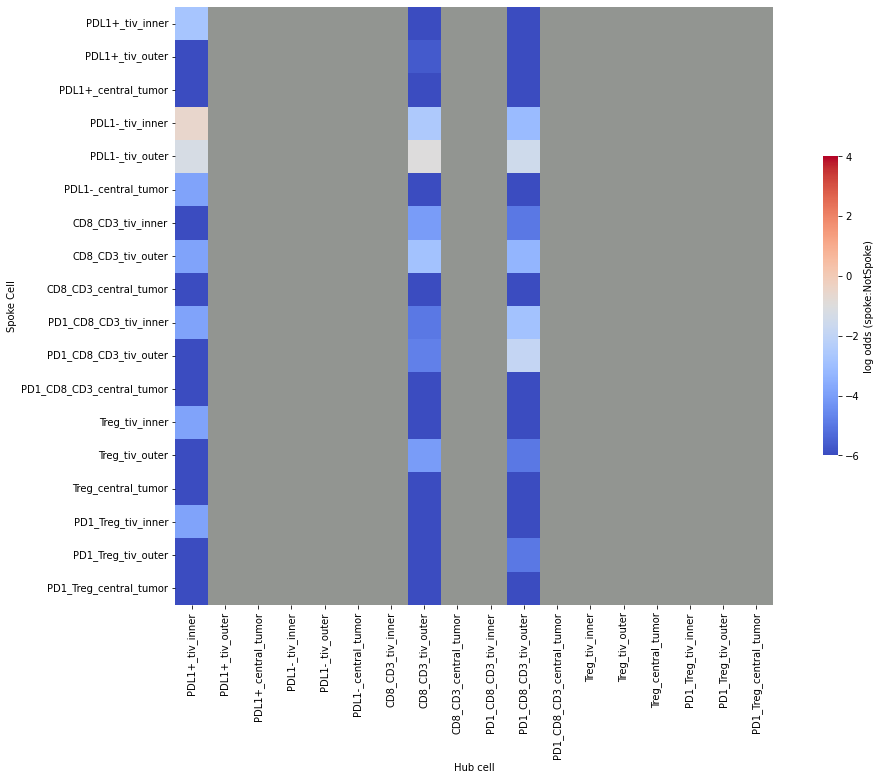

In [36]:
cell_names = [x for x in multi_label_types.keys()]
keep_cx = []
fig = plt.figure(figsize=(18,11))
i = 1
start = time.time()
out_stack = []
use_cells = [x for x in multi_label_types.keys()] #['CD8: CD3', 'PanCK: PD-L1','FOXP3: CD3']
col_dict = {'tissue_col': 'Parent',
            'cell_col': 'cell_type',
            'cell_x_pos' : 'Centroid X µm',
            'cell_y_pos' : 'Centroid Y µm'}
idx = ~df.loc[:,col_dict['cell_col']].isna()
subset=df.loc[idx,:].reset_index()
max_dist = 35
scale = 1

print('Beginning cell connection detection...')

# if evaluating tumor margin, require minimum number of stromal cells of any kind
# be present--> delHelpers.cell_dist_criterion()
tissue_crit = {'Outer margin': 0} #Tissue type & min number of cells > 0
connections = delHelpers.df_to_connections_output(subset,
                                                  hub_cells = ['PDL1+_tiv_inner',
                                                              'CD8_CD3_tiv_outer',
                                                               'PD1_CD8_CD3_tiv_outer',
                                                               ],
                                                               #'PDL1-_tiv_inner'], PDL1- takes a long time
                                                  scale = scale,
                                                  max_dist = max_dist,
                                                  col_dict = col_dict,
                                                  tissue_crit = tissue_crit,                                                 
                                                  )

delcx = delHelpers.generate_log_odds_matrix(connections,
                                             cell_names, #Need a version that is hub cells vs. all cells?
                                             version = 1)
stop = time.time()
print('Processing time: %2.2f minutes.' % ((stop-start)/60))
out_stack.append(delcx)
ax = fig.add_subplot(1,1,i,aspect='equal')
ax = delPlots.connection_heatmap(delcx, 
                                 cell_names,
                                 ax = ax
                                )
# ax.set_title(lab)

if i > 1:
    ylabel=''
else:
    ylabel = 'Spoke Cell'
ax.set_ylabel(ylabel)
# new_fn =jobid + '_' \
#         +  fn.parts[-1].split(']_')[0] \
#         + ']_delaunay_cx_%s' % lab

# print('Saving %s' % new_fn )

# #Save full connectivity:
# out_fn = output.joinpath(new_fn + '.csv')
# connections.to_csv(out_fn)

# # #Save stack out log-odds connectivity matrices
# # out_fn = output.joinpath(new_fn + '.npy')
# # np.save(out_fn, arr=delcx, allow_pickle=False)

# i = i + 1
stop = time.time()
print('Processing time: %2.2f minutes.' % ((stop-start)/60))
print('Finished!')


In [20]:
old_cx = delcx

In [37]:
old_cx.shape

(18, 18)

In [39]:
old_cx[:,0] - delcx[:,0]


array([ 1.69470439,  0.        ,  5.12197788,  0.77404631, -1.84381383,
        0.06978607,  4.02437005, -1.31955783,  0.        , -0.22195   ,
        0.        ,  0.        , -1.31955783,  0.        ,  0.        ,
       -1.31955783,  0.        ,  0.        ])

In [107]:
all_cx.hub_cell.unique()

array(['CD3', 'FOXP3: CD3', 'CD8: CD3', 'CD8', 'PD-1: CD3'], dtype=object)

In [98]:
all_cx.groupby(['cx_cell'])['cx_tissue'].count()

cx_cell
CD8_CD3_tiv_inner         19
CD8_CD3_tiv_outer         38
PD1_CD8_CD3_tiv_inner     24
PD1_CD8_CD3_tiv_outer     24
PD1_Treg_tiv_inner         2
PD1_Treg_tiv_outer         2
PDL1+_central_tumor        8
PDL1+_tiv_inner           49
PDL1+_tiv_outer            2
PDL1-_central_tumor      429
PDL1-_tiv_inner          164
PDL1-_tiv_outer          192
Treg_tiv_inner             1
Treg_tiv_outer            11
Name: cx_tissue, dtype: int64

In [76]:
import pdb

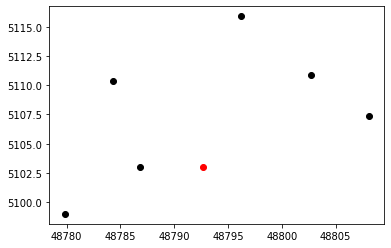

In [32]:
use = np.array([30,34,35,3878,3903,3945])
plt.plot(tri.points[use,0],tri.points[use,1],'ok')
plt.plot(tri.points[25,0],tri.points[25,1],'ro')

# Saving / loading this output ~4mb .csv file size not too bad.

In [82]:
out_fn = results.joinpath('neighborhoods').joinpath('test.csv')
connections.to_csv(out_fn)

In [7]:
# out_fn = results.joinpath('neighborhoods').joinpath('test.csv')
out_fn = results.joinpath('neighborhods/v0').joinpath(
connections = pd.read_csv(out_fn)
connections.head()

,Unnamed: 0,cx_cell,cx_tissue,hub_id,hub_cell
0,0,PanCK+,Tumor,0,CD20+
1,1,Others,Tumor,0,CD20+
2,2,Others,Tumor,0,CD20+
3,3,CD20+,Immune Cell Cluster,0,CD20+
4,4,PanCK+,Others,0,CD20+


# Example: calculate log odds of connectivity

Text(32.99999999999999, 0.5, 'Spoke cell')

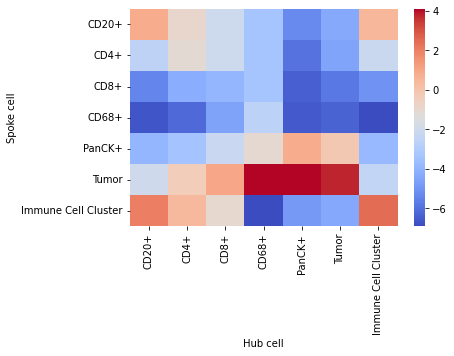

In [8]:
cell_names = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+',
              'Tumor',
              'Immune Cell Cluster',
             ] #     none of these in example core:  'AF/Macrophage Cluster'

cx_cells = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+']

cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']

use_cells = connections.loc[:,'cx_cell'].isin(cell_names)
use_tissues = use_cells = connections.loc[:,'cx_tissue'].isin(cell_names)
use_cx = use_cells | use_tissues

output = np.zeros((len(cell_names),len(cell_names)))
for i,hub_type in enumerate(cell_names):
    for j,spoke_type in enumerate(cell_names):
        use_hub = connections.loc[:,'hub_cell'].values == hub_type
        if any([spoke_type == x for x in cx_tissues]):
            use_spoke = connections.loc[:,'cx_tissue'] == spoke_type
        else:
            use_spoke = connections.loc[:,'cx_cell'] == spoke_type
        a = np.sum(use_hub & use_spoke) #Total n connections of hub-type i to spoke-type j.
        na = np.sum(use_hub & ~use_spoke) #Total n connections of hub-type i to Not spoke-type j.
        output[j,i] = a / na
output = np.log(output+.01)

sns.heatmap(output,
            cmap = 'coolwarm',
            xticklabels=cell_names,
            yticklabels=cell_names)
plt.xlabel('Hub cell')
plt.ylabel('Spoke cell')
plt.title(txt[0].parts[-1]);
    

In [49]:
connections.head()

,Unnamed: 0,cx_cell,cx_tissue,dist_um,hub_id,cx_id,hub_cell
0,0,CD4+,Immune Cell Cluster,15.689487,152,82,CD20+
1,1,Others,Immune Cell Cluster,14.933519,152,2818,CD20+
2,2,CD4+,Immune Cell Cluster,12.907750,152,2840,CD20+
3,3,CD4+,Immune Cell Cluster,5.700877,152,2850,CD20+
4,4,CD4+,Immune Cell Cluster,11.764778,152,9614,CD20+


In [12]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']


def connection_heatmap(output,
                       cell_names,
                       label = 'log odds (spoke:NotSpoke)',
                       ylabel='Spoke Cell',
                       vmin = -6,
                       vmax = 4,
                       ax = None):    
    if ax==None:
        fig = plt.figure(figsize=[8,8],)
        ax = fig.add_subplot(1,1,1,aspect='equal')
    g = sns.heatmap(output,
                square=True,
                cmap = 'coolwarm',
                xticklabels=cell_names,
                yticklabels=cell_names,
                ax=ax,
                vmin = vmin,
                vmax = vmax,
                cbar_kws={"shrink": 0.5,
                         'label': label})

    g.set_facecolor('xkcd:gray')
    ax.set_xlabel('Hub cell')
    ax.set_ylabel(ylabel)
    return ax
# ax = connection_heatmap(output,cell_names)

In [36]:
# Thought: might be worth putting back in odds:
# Odds spoke:notSpoke | hub
print('odds')
print([math.exp(x) for x in range(-8,4,2)])

# % of connectionsb
print([math.exp(x)/(math.exp(x)+1) * 100 for x in range(-8,4,2)])

odds
[0.00033546262790251185, 0.0024787521766663585, 0.01831563888873418, 0.1353352832366127, 1.0, 7.38905609893065]
[0.03353501304664781, 0.24726231566347748, 1.7986209962091555, 11.920292202211755, 50.0, 88.07970779778825]


# Loop through all cores and save .png of log odds matrices

In [ ]:
output_v0 =  results.joinpath('neighborhoods/v0')
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'FoxP3+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']
max_dist=25
qct=50
filelist=[fn for fn in output_v0.glob('*.csv')]
save_all = True
for fn in filelist:
    connections = pd.read_csv(fn)
    idx = connections.loc[:,'dist_um'].values < max_dist
    connections = connections.loc[idx,:]
    output = delHelpers.generate_log_odds_matrix(connections,
                                  cell_names,
                                 cx_cells,
                                 cx_tissues)
    ax = connection_heatmap(output,cell_names)
    temp = fn.parts[-1].split('.')[0]
    ax.set_title(temp);
    out_fn = '%s_qc-%d_dist-%d.png' % (temp,qct,max_dist)
    print(out_fn)
    if save_all ==True:
        plt.savefig(output_v0.joinpath(out_fn))
print('Finished')

# Loop through .csv outputs from parallel pipeline and stack output

In [10]:
output_v0 =  results.joinpath('neighborhoods/v0')
output_pn =  results.joinpath('neighborhoods')
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
cx_cells = ['CD20+',
          'CD4+',
          'CD8+',
          'CD68+',
          'FoxP3+',
          'PanCK+']
cx_tissues = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']
max_dist=25
qct=50
filelist=[fn for fn in output_v0.glob('*.csv')]
save_all = True
keep = []
start_time = time.time()
for fn in filelist:
    connections = pd.read_csv(fn)
    idx = connections.loc[:,'dist_um'].values < max_dist
    connections = connections.loc[idx,:]
    output = delHelpers.generate_log_odds_matrix(connections,
                                                 cell_names,
                                                 cx_cells,
                                                 cx_tissues)
    keep.append(output)
all_outs = np.stack(keep, axis = 2)
all_outs[np.isinf(all_outs)]= 4 #math.expr(4) = ~50:1
print('Saving:')
new_fn = 'log_odds_whole_core_deltri_n-%d_qc-%d_dist-%d_v2.npy' % (all_outs.shape[2],qct,max_dist)
np.save(output_pn.joinpath(new_fn),arr=all_outs,allow_pickle=False)
print(output_pn.joinpath(new_fn))
df = pd.DataFrame({'fn':filelist})
new_fn = 'fns_whole_core_deltri_n-%d_qc-%d_dist-%d_v2.csv' % (all_outs.shape[2],qct,max_dist)
df.to_csv(output_pn.joinpath(new_fn))
print(output_pn.joinpath(new_fn))
print(all_outs.shape)
print('%2.1f seconds' % (time.time()-start_time))

Saving:
/mnt/results/neighborhoods/log_odds_whole_core_deltri_n-305_qc-50_dist-25_v2.npy
/mnt/results/neighborhoods/fns_whole_core_deltri_n-305_qc-50_dist-25_v2.csv
(9, 9, 305)
127.2 seconds


# Plot mean connection matrix

(9, 9, 305)


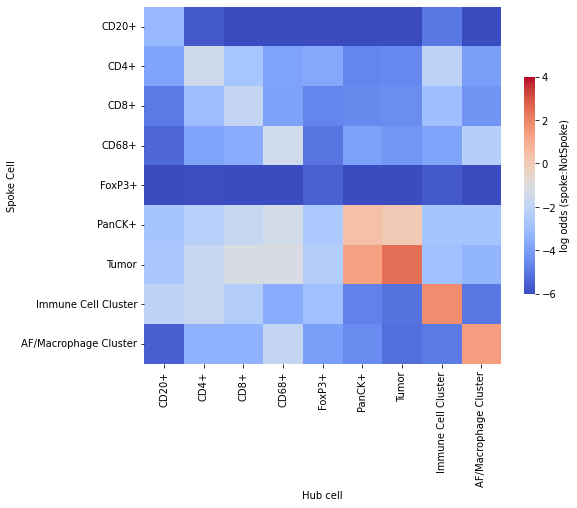

In [16]:
print(all_outs.shape)
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
temp = all_outs
# temp[np.isinf(all_outs)] = 4 #Value for cores where hub cell only connects to one type of spoke cell (probably low n)
m_out = np.nanmean(temp,axis=2)
# m_out = zscore(m_out)
ax = connection_heatmap(m_out,cell_names)
# plt.imshow()


# Load enough data to make this interesting

In [17]:
fns = pd.read_csv('/mnt/results/neighborhoods/fns_whole_core_deltri_n-305_qc-50_dist-25_v2.csv')
all_core_codes = tls.seg_fn_to_unique_tma_code(fns.fn)
connections = np.load('/mnt/results/neighborhoods/log_odds_whole_core_deltri_n-305_qc-50_dist-25_v2.npy')
tls_full = pd.read_pickle('/mnt/results/all_tls_features_with_clinical_UMAP_size_and_pattern.pkl')
tma_id = np.unique(tls_full.loc[:,'unique_TMA_Code'])
n_tma = len(tma_id)
has_tls = ~ (tls_full['tls_id'].values == "None")
good_tls = tls_full['tls_is_good'].values
use_tls =  good_tls
idx = tls_full.loc[use_tls,'unique_TMA_Code'].isin(all_core_codes)
print('Unique TLS found in cores n =',np.sum(idx.values))
tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
print('Unique cores in TLS n =', len(tls_cores))
tls_core_idx = pd.Series(all_core_codes).isin(tls_cores).values
print('Unique TLS cores found in all cores n =' ,np.sum(tls_core_idx))

Unique TLS found in cores n = 163
Unique cores in TLS n = 90
Unique TLS cores found in all cores n = 90


# Connections: Compare TLS to No TLS

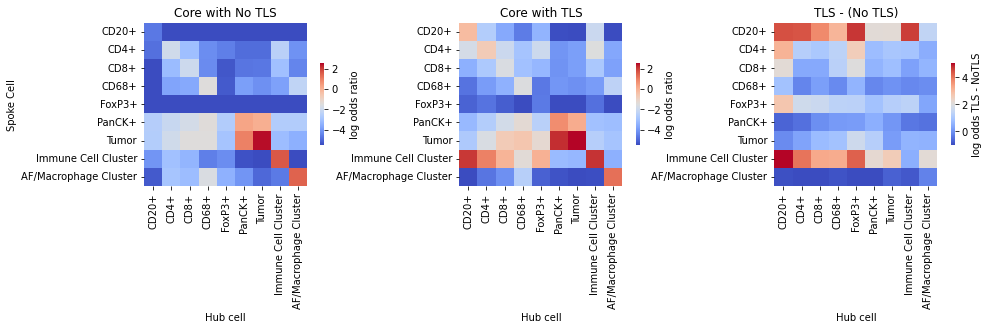

In [18]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
      ]
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[16,3],)
ids = [~tls_core_idx, tls_core_idx]
labs = ['Core with No TLS', 'Core with TLS']
i = 1   
keep = []
for idx,lab in zip(ids,labs):
    ax = fig.add_subplot(1,3,i,aspect='equal')    
    temp = connections[:,:,idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax = connection_heatmap(m_out, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            label='log odds ratio',
                            vmin = -5.5,
                            vmax = 2.5,
                            ax=ax)
    ax.set_title(lab)
    i = i +1
ax = fig.add_subplot(1,3,i,aspect='equal')
tls_diff = keep[1]-keep[0]
ax = connection_heatmap(tls_diff,
                        np.array(cell_names)[use],
                        ax = ax,
                        ylabel='',
                        vmin = -1,
                        vmax = 5,
                        label = 'log odds TLS - NoTLS')
ax.set_title('TLS - (No TLS)');

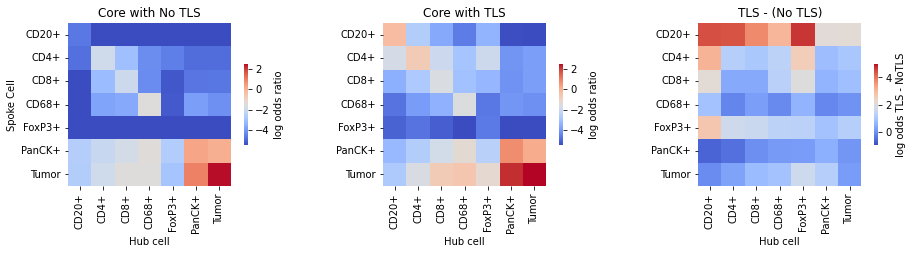

In [19]:
cell_names = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           'Immune Cell Cluster',
           'AF/Macrophage Cluster',
          ]
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
      ]

#More stringent ? no not really different
# tls_and_agg_cores = np.unique(tls_full.loc[has_tls,'unique_TMA_Code'].values) #includes non-tls aggregates
# no_tls_core_idx = ~pd.Series(all_core_codes).isin(tls_and_agg_cores).values
# print(np.sum(no_tls_core_idx))

no_tls_core_idx = ~tls_core_idx
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[16,3],)
ids = [no_tls_core_idx, tls_core_idx]
labs = ['Core with No TLS', 'Core with TLS']
i = 1   
keep = []
for idx,lab in zip(ids,labs):
    ax = fig.add_subplot(1,3,i,aspect='equal')    
    temp = connections[:,:,idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax = connection_heatmap(m_out, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            vmin = -5.5,
                            vmax = 2.5,
                            label='log odds ratio',
                            ax=ax)
    ax.set_title(lab)
    i = i +1
ax = fig.add_subplot(1,3,i,aspect='equal')
tls_diff = keep[1]-keep[0]
ax = connection_heatmap(tls_diff,
                        np.array(cell_names)[use],
                        ax = ax,
                        ylabel='',
                        vmin = -1,
                        vmax = 5,
                        label = 'log odds TLS - NoTLS')
ax.set_title('TLS - (No TLS)');

# TODO:
- refine TLS
- perform connectivity analysis just on TLS cell regions
- cluster TLS

In [114]:
tls_full.head()

,PID,Condition,Block,TMA_Number,TMA_Core,segmented_TMA_Code,unique_TMA_Code,PID.1,CommentBD,Sex,...,tls_neighbor_per_CD68+,tls_neighbor_xy_CD68+,tls_neighbor_per_FoxP3+,tls_neighbor_xy_FoxP3+,tls_neighbor_per_PanCK+,tls_neighbor_xy_PanCK+,pattern_based_UMAP_cluster_ids,pattern_based_UMAP_0,pattern_based_UMAP_1,is_TMA01
0,00044-3,adj,G,1.0,"1,I","[1,1,I]","TMA01_Core[1,1,I]",443.0,NaN,female,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,1.565858,"[[40607.3, 6456.4], [40909.1, 6500.1], [40856....",0.030703,"[[40967.8, 6718.9]]",0.153516,"[[40351.2, 6474.3], [40679.4, 6727.4], [40907....",NaN,NaN,NaN,True
2,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,1.359867,"[[39949.0, 6504.6], [40333.8, 6657.7], [40315....",0.000000,[],2.321725,"[[40183.7, 6430.0], [39843.6, 6579.2], [39848....",NaN,NaN,NaN,True
3,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,0.431144,"[[40909.1, 6500.1], [40856.4, 6536.4], [40898....",0.025361,"[[40967.8, 6718.9]]",2.891200,"[[40692.8, 7028.2], [40638.1, 7077.9], [40729....",NaN,NaN,NaN,True
4,00044-3,primary,H,1.0,"1,C","[1,1,C]","TMA01_Core[1,1,C]",443.0,NaN,female,...,0.830406,"[[40172.7, 6744.8], [40111.1, 6765.1], [40295....",0.000000,[],5.301821,"[[40061.3, 6844.2], [39932.6, 6872.5], [40328....",NaN,NaN,NaN,True


# Plot core-level connection matrix by spatial group

In [120]:
print(np.sum(use),cid)

30 0


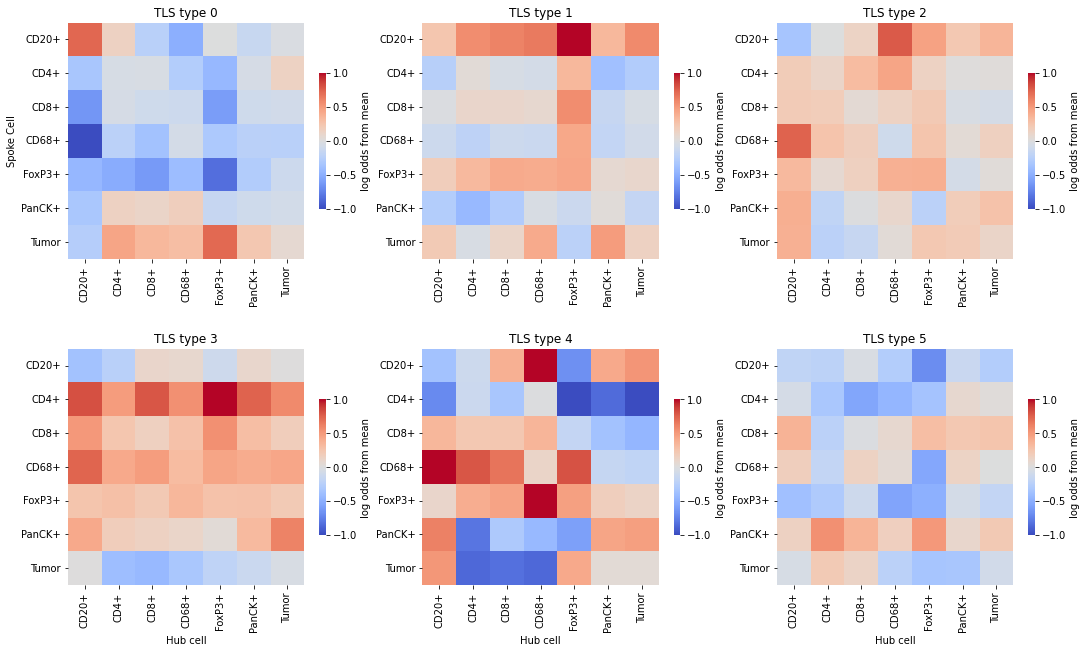

In [24]:
use_cells = ['CD20+',
           'CD4+',
           'CD8+',
           'CD68+',
           'FoxP3+',
           'PanCK+',
           'Tumor',
           # 'Immune Cell Cluster',
           # 'AF/Macrophage Cluster',
      ]
use = np.array(pd.Series(cell_names).isin(use_cells))
fig = plt.figure(figsize=[18,11],)
cluster_ids = [x for x in range(0,6)]
labs = [str(x) for x in cluster_ids]
i = 1   
keep = []
temp = connections[:,:, tls_core_idx]
temp = temp[use,:,:]
temp = temp[:,use,:]
m_out_all = np.nanmean(temp,axis=2) # m_out = zscore(m_out)

mean_tls =  np.nanmean(connections,axis=2)

# ax = connection_heatmap(m_out,cell_names)
for cid,lab in zip(cluster_ids,labs):
    ax = fig.add_subplot(2,3,i,aspect='equal') 
    # 
    cluster_idx = tls_full.loc[:,'pattern_based_UMAP_cluster_ids'].values == cid
    use_tls = good_tls & cluster_idx
    tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
    tls_core_type_idx = pd.Series(all_core_codes).isin(tls_cores).values    
    temp = connections[:,:,tls_core_type_idx]
    temp = temp[use,:,:]
    temp = temp[:,use,:]
    m_out = np.nanmean(temp,axis=2) # m_out = zscore(m_out)
    keep.append(m_out)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    
    ax = connection_heatmap(m_out-m_out_all, 
                            np.array(cell_names)[use],
                            ylabel = ylabel,
                            label='log odds from mean',
                            vmin = -1,# -5.5,
                            vmax = 1, #2.5,
                            ax=ax)
    if i < 4:
        # ax.set_xticks([])
        ax.set_xlabel('')
        
    ax.set_title('TLS type %s' % lab)
    i = i +1
